# Import Data  
This coding practice was designed for 3 hour completion in class.  Learners will fill the incomplete codes (None) to make them complete.  Given a project structure as follows  
- Project  
  - src  
  - data  
  - plot  

Your `.ipynb` file was saved in the `src` folder and your data was saved in the `data` folder.  We learned how to import data until data preparation from the previous lab.  Let's reuse it again starting from import data.

In [1]:
import pandas as pd

df = pd.read_excel("../data/ENB2012_data.xlsx", sheet_name="data")

The original data does not have a categorical label whether a building is an energy-saving or not.  We created a utility function to derive such label from heating load (hl) and cooling load (cl).

In [2]:
import numpy as np

def getlabel(hl, cl, alpha=1):
    if np.abs(hl - cl) - alpha >= 0:
        return 1
    else:
        return 0

Create a target class using the `getlabel` function.

In [3]:
df["is_energy_saving"] = df.apply(lambda x: getlabel(x["Y1"], x["Y2"]), axis=1)

Although the `decision tree` can work with categorical data, implementation in `scikit-learn` does not support.  We need to create dummy variables to handle.

In [4]:
df["orientation"] = df["X6"].map({2: "north", 3: "east", 4: "south", 5: "west"})
orientation = pd.get_dummies(df["orientation"])
df = pd.concat([df, orientation], axis=1)

# Data Splitting  

Data splitting relies on randomization processes.  To make a reproducable experiment, we will set a random seed first.  
 We will split the original data into 3 dataframes: `train` (70%), `test` (15%), `val` (15%).  For the consistent splitting, we will split the original data to remain:test at 85:15 then split the remain data to train:val at 70:15 with respect to the size of original data.  The prepare `X` and `y` from the original dataframe `df`.

In [5]:
from sklearn.model_selection import train_test_split

seed = 433 # Set random seed

remain, test = train_test_split(df, test_size=int(np.floor(0.15 * len(df.index))), 
                                stratify=df["is_energy_saving"], random_state=seed)

train, val = train_test_split(remain, test_size=int(np.floor(0.15 * len(df.index))), 
                              stratify=remain["is_energy_saving"], random_state=seed)

Defiine your full dataset `X` and `y` from the dataframe `df`.  The `X` takes `X1`, `X2`, `X3`, `X4`, `X5`, `east`, `south`, `west`, and `X7` as features.  The target `y` is `is_energy_saving`.

In [6]:
X = df.loc[:, ["X1", "X2", "X3", "X4", "X5", "east", "south", "west", "X7"]].values
y = df["is_energy_saving"].values.ravel()

Make sure that the class distribution in `train`, `val`, and `test` are almost the same by using visualization.

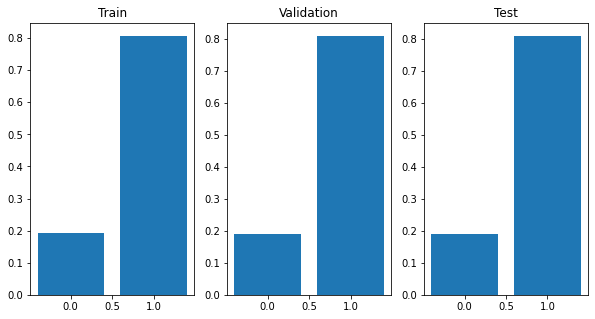

In [7]:
import matplotlib.pyplot as plt

train_dist = train.groupby("is_energy_saving").size().reset_index(name="#")
train_dist["%"] = train_dist["#"] / train_dist["#"].sum()

val_dist = val.groupby("is_energy_saving").size().reset_index(name="#")
val_dist["%"] = val_dist["#"] / val_dist["#"].sum()

test_dist = test.groupby("is_energy_saving").size().reset_index(name="#")
test_dist["%"] = test_dist["#"] / test_dist["#"].sum()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax[0].bar(train_dist["is_energy_saving"], train_dist["%"])
ax[0].set_title("Train")
ax[1].bar(val_dist["is_energy_saving"], val_dist["%"])
ax[1].set_title("Validation")
ax[2].bar(test_dist["is_energy_saving"], test_dist["%"])
ax[2].set_title("Test")
plt.show()

# Modeling  
`RandomSearchCV` and `GridSearchCV` were applied as our model tuning strategies.  The `RandomSearchCV` was applied first to determine roughly optimal set of hyperparameters on the hyperplane.  There are several hyperparameters can be tuned.  For understanding purpose, our tutorials will tune only 2 hyperparameters: `max_depth` and `max_leaf_nodes`.  

**Tips & Tricks**: You are going to conduct a machine learning experiment with more than one model.  Managing your workspace is important.  There are ways to do.  This tutorials introduce a way to use python dictionary to handle your variables in workspace.  Imagine that you have created a variable to measure precision of `model1`.  What should be a variable to store the precision of `model2`?  Perhaps using `precision1` and `precision2` could work but it is not scalable if your experiment has, for example, ten models.  Instead of doing such a way, we can use a dictionary as a name `precision` then use the key for each model name to store precision values.  The rest of coding follows such idea.  

**Activity 1**: Create a hyperplane for `RandomSearchCV` of two hyperparameters: `max_depth` and `max_leaf_nodes`.  The `max_depth` will be randomly tuned between 3 to 8.  The `max_leaf_nodes` will be randomly tuned between 10 to 30.  We will use `dt` and `rf` to represent the name of `decision tree` and `random forest` respectively.  

In [8]:
rd_hparams = {}
depth = {}
leaf = {}

np.random.seed(seed)
depth["dt"] = np.random.randint(3, 8, size=5)

np.random.seed(seed)
leaf["dt"] = np.random.randint(10, 30, size=5)

np.random.seed(seed)
depth["rf"] = np.random.randint(3, 8, size=5)

np.random.seed(seed)
leaf["rf"] = np.random.randint(10, 30, size=5)

rd_hparams["dt"] = dict(max_depth=depth["dt"], max_leaf_nodes=leaf["dt"])
rd_hparams["rf"] = dict(max_depth=depth["rf"], max_leaf_nodes=leaf["rf"])

Let's visualize our hyperplane and our randomization.  For comparison purpose, we use the same randomization for `decision tree` and `random forest`.

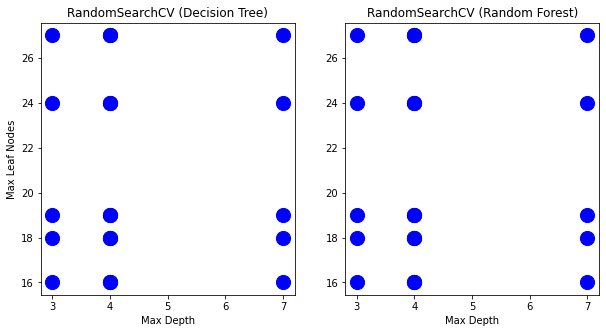

In [9]:
from itertools import product

combin = {}
combin["dt"] = pd.DataFrame(list(product(*(depth["dt"], leaf["dt"]))), columns=["depth", "leaf"])
combin["rf"] = pd.DataFrame(list(product(*(depth["rf"], leaf["rf"]))), columns=["depth", "leaf"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].scatter(combin["dt"]["depth"], combin["dt"]["leaf"], color="blue", s=200)
ax[0].set_xlabel("Max Depth")
ax[0].set_ylabel("Max Leaf Nodes")
ax[0].set_title("RandomSearchCV (Decision Tree)")

ax[1].scatter(combin["rf"]["depth"], combin["rf"]["leaf"], color="blue", s=200)
ax[1].set_xlabel("Max Depth")
ax[1].set_title("RandomSearchCV (Random Forest)")

plt.show()

**Activity 2**: Initialize a `decision tree` and a `random forest`.  Make them learn from `balanced` class distribution.  Ensure that the random seed has been set.  The `random forest` needs to define the number of trees (estimator).  Let's set it to 15.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dt = DecisionTreeClassifier(class_weight="balanced", random_state=seed)
rf = RandomForestClassifier(n_estimators=15, class_weight="balanced", random_state=seed)

**Activity 3**: Fit models to its RandomSearchCV using the predefined hyperplane.

In [11]:
from sklearn.model_selection import RandomizedSearchCV

rand_tune = {}
rand_tune["dt"] = RandomizedSearchCV(dt, 
                                     rd_hparams["dt"], 
                                     random_state=seed, 
                                     cv=[(train.index, val.index)], 
                                     scoring="accuracy")

rand_tune["rf"] = RandomizedSearchCV(rf, 
                                     rd_hparams["rf"], 
                                     random_state=seed, 
                                     cv=[(train.index, val.index)], 
                                     scoring="accuracy")

rand_search = {}
rand_search["dt"] = rand_tune["dt"].fit(X, y)
rand_search["rf"] = rand_tune["rf"].fit(X, y)

Explore the best `decision tree` from RandomSearchCV.

In [12]:
rand_search["dt"].best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=7, max_leaf_nodes=18,
                       random_state=433)

Explore the best `random forest` from RandomSearchCV.

In [13]:
rand_search["rf"].best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=7, max_leaf_nodes=19,
                       n_estimators=15, random_state=433)

**Activity 4**: Create a grid hyperplane from the best estimator obtained from RandomSearchCV.  Let's make the $7 \times 7$ grids where the center is the hyperparameter obtained from RandomSearchCV.

In [14]:
from sklearn.model_selection import GridSearchCV

xgrid = {}
xgrid["dt"] = [rand_search["dt"].best_estimator_.max_depth + i for i in range(-3, 4)]
xgrid["rf"] = [rand_search["rf"].best_estimator_.max_depth + i for i in range(-3, 4)]

ygrid = {}
ygrid["dt"] = [rand_search["dt"].best_estimator_.max_leaf_nodes + i for i in range(-3, 4)]
ygrid["rf"] = [rand_search["rf"].best_estimator_.max_leaf_nodes + i for i in range(-3, 4)]

gd_hparams = {}
gd_hparams["dt"] = {"max_depth": xgrid["dt"],
                    "max_leaf_nodes": ygrid["dt"]}
gd_hparams["rf"] = {"max_depth": xgrid["rf"],
                    "max_leaf_nodes": ygrid["rf"]}

Visualize the grid hyperplane.

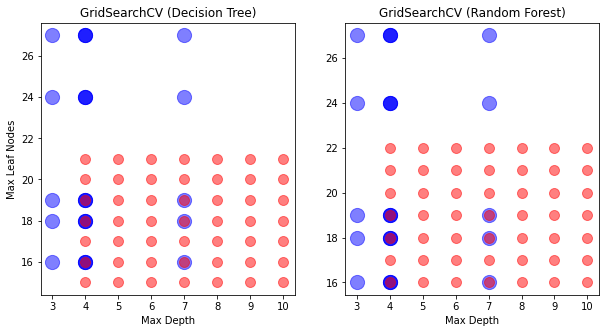

In [15]:
grid = {}
grid["dt"] = pd.DataFrame(list(product(*(xgrid["dt"], ygrid["dt"]))), columns=["depth", "leaf"])
grid["rf"] = pd.DataFrame(list(product(*(xgrid["rf"], ygrid["rf"]))), columns=["depth", "leaf"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].scatter(combin["dt"]["depth"], combin["dt"]["leaf"], color="blue", alpha=0.5, s=200)
ax[0].scatter(grid["dt"]["depth"], grid["dt"]["leaf"], color="red", alpha=0.5, s=100)
ax[0].set_xlabel("Max Depth")
ax[0].set_ylabel("Max Leaf Nodes")
ax[0].set_title("GridSearchCV (Decision Tree)")

ax[1].scatter(combin["rf"]["depth"], combin["rf"]["leaf"], color="blue", alpha=0.5, s=200)
ax[1].scatter(grid["rf"]["depth"], grid["rf"]["leaf"], color="red", alpha=0.5, s=100)
ax[1].set_xlabel("Max Depth")
ax[1].set_title("GridSearchCV (Random Forest)")

plt.show()

**Activity 5**: Fine-tune models to the grid hyperplane.

In [16]:
from sklearn.model_selection import GridSearchCV

clf = {}
clf["dt"] = DecisionTreeClassifier(class_weight="balanced", random_state=seed)
clf["rf"] = RandomForestClassifier(class_weight="balanced", random_state=seed)

grid_tune = {}
grid_tune["dt"] = GridSearchCV(clf["dt"], gd_hparams["dt"], cv=[(train.index, val.index)], scoring="accuracy")
grid_tune["rf"] = GridSearchCV(clf["rf"], gd_hparams["dt"], cv=[(train.index, val.index)], scoring="accuracy")

grid_search = {}
grid_search["dt"] = grid_tune["dt"].fit(X, y)
grid_search["rf"] = grid_tune["rf"].fit(X, y)

Explore the best `decision tree` from GridSearchCV.

In [17]:
grid_search["dt"].best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=15,
                       random_state=433)

Explore the best `random forest` from GridSearchCV.

In [18]:
grid_search["rf"].best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=7, max_leaf_nodes=20,
                       random_state=433)

The best hyperparameters for `decision tree` and `random forest` were shown in the `green dot`.

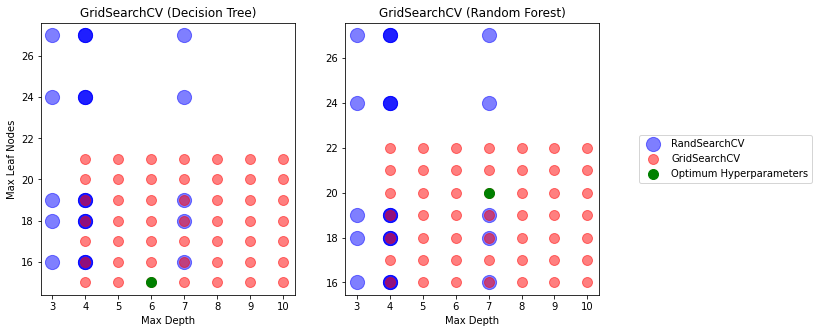

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].scatter(combin["dt"]["depth"], combin["dt"]["leaf"], color="blue", alpha=0.5, s=200, label="RandSearchCV")
ax[0].scatter(grid["dt"]["depth"], grid["dt"]["leaf"], color="red", alpha=0.5, s=100, label="GridSearchCV")
ax[0].scatter([grid_search["dt"].best_estimator_.max_depth], [grid_search["dt"].best_estimator_.max_leaf_nodes], 
              color="green", s=100, label="Optimum Hyperparameters")
ax[0].set_xlabel("Max Depth")
ax[0].set_ylabel("Max Leaf Nodes")
ax[0].set_title("GridSearchCV (Decision Tree)")

ax[1].scatter(combin["rf"]["depth"], combin["rf"]["leaf"], color="blue", alpha=0.5, s=200, label="RandSearchCV")
ax[1].scatter(grid["rf"]["depth"], grid["rf"]["leaf"], color="red", alpha=0.5, s=100, label="GridSearchCV")
ax[1].scatter([grid_search["rf"].best_estimator_.max_depth], [grid_search["rf"].best_estimator_.max_leaf_nodes], 
              color="green", s=100, label="Optimum Hyperparameters")
ax[1].set_xlabel("Max Depth")
ax[1].set_title("GridSearchCV (Random Forest)")

plt.legend(bbox_to_anchor=(1.5, 0.5), loc="center")
plt.show()

# Prediction and Inference  

The trained model is ready for prediction.  Use `predict_proba` to estimate prediction probability.  
**Activity 6**: Estimate prediction probability for both models.

In [20]:
probs = {}
probs["dt"] = grid_search["dt"].best_estimator_.predict_proba(X[test.index])
probs["rf"] = grid_search["rf"].best_estimator_.predict_proba(X[test.index])

Model calibration helps to get better inference the predicted labels by determining the cutoff probability from the `training data`.  Without calibration, the default cutoff in `scikit-learn` is set at 0.5 and can be directly inference via `predict`. Basic idea to derive the optimum cutoff is the `ROC curve` where the optimum cutoff makes the curve approch to the top left corner.  Therefore, the optimum cutoff yields the maximum difference between `TPR` (True-Positive Rate) and `FPR` (False-Positive Rate).  

**Activity 7**: Use `roc_curve` to determine the optimum cutoff.

In [21]:
from sklearn.metrics import roc_curve

p = {}
p["dt"] = grid_search["dt"].best_estimator_.predict_proba(X[train.index])
p["rf"] = grid_search["rf"].best_estimator_.predict_proba(X[train.index])

fpr = {}
tpr = {}
thresholds = {}
fpr["dt"], tpr["dt"], thresholds["dt"] = roc_curve(y_true=y[train.index], y_score=p["dt"][:, 1], pos_label=1)
fpr["rf"], tpr["rf"], thresholds["rf"] = roc_curve(y_true=y[train.index], y_score=p["rf"][:, 1], pos_label=1)

idx = {}
idx["dt"] = np.argmax(tpr["dt"] - fpr["dt"])
idx["rf"] = np.argmax(tpr["rf"] - fpr["rf"])

cutoff = {}
cutoff["dt"] = thresholds["dt"][idx["dt"]]
cutoff["rf"] = thresholds["rf"][idx["rf"]]

print("The optimum cutoff for decision tree is {}".format(round(cutoff["dt"], 3)))
print("The optimum cutoff for random forest is {}".format(round(cutoff["rf"], 3)))

The optimum cutoff for decision tree is 0.544
The optimum cutoff for random forest is 0.505


**Activity 8**: Make label prediction from the cutoff.

In [22]:
yhat = {}
yhat["dt"] = (probs["dt"][:, 1] >= cutoff["dt"]).astype(int)
yhat["rf"] = (probs["rf"][:, 1] >= cutoff["rf"]).astype(int)

# Evaluation  

Model performance evaluation starts from deriving a confusion matrix.  Performance metrics such as `precision`, `recall`, `F1`, and `accuracy` can be obtained from the confusion matrix. 

**Activity 9**: Get the confusion matrix.

In [23]:
from sklearn.metrics import confusion_matrix

cmat = {}
cmat['dt"'] = confusion_matrix(y[test.index], yhat["dt"])
cmat['rf"'] = confusion_matrix(y[test.index], yhat["rf"])

print(cmat)

{'dt"': array([[20,  2],
       [21, 72]], dtype=int64), 'rf"': array([[20,  2],
       [19, 74]], dtype=int64)}


For binary classification, each count is located as follows.  
- `TP`: cmat[1, 1]  
- `TN`: cmat[0, 0]  
- `FP`: cmat[0, 1]  
- `FN`: cmat[1, 0]

**Activity 10**: Measure `precision`, `recall`, `F1`, and `accuracy`.

In [24]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

precision = {}
precision["dt"] = precision_score(y[test.index], yhat["dt"])
precision["rf"] = precision_score(y[test.index], yhat["rf"])

recall = {}
recall["dt"] = recall_score(y[test.index], yhat["dt"])
recall["rf"] = recall_score(y[test.index], yhat["rf"])

accuracy = {}
accuracy["dt"] = accuracy_score(y[test.index], yhat["dt"])
accuracy["rf"] = accuracy_score(y[test.index], yhat["rf"])

f1 = {}
f1["dt"] = f1_score(y[test.index], yhat["dt"])
f1["rf"] = f1_score(y[test.index], yhat["rf"])

print("Model performance (dt, rf) are the following.")
print("Precision are ({}, {})".format(round(precision["dt"], 3), round(precision["rf"], 3)))
print("Recall are ({}, {})".format(round(recall["dt"], 3), round(recall["rf"], 3)))
print("Accuracy are ({}, {})".format(round(accuracy["dt"], 3), round(accuracy["rf"], 3)))
print("F1 are ({}, {})".format(round(f1["dt"], 3), round(f1["rf"], 3)))

Model performance (dt, rf) are the following.
Precision are (0.973, 0.974)
Recall are (0.774, 0.796)
Accuracy are (0.8, 0.817)
F1 are (0.862, 0.876)


Our results follow the theory that `random forest` is better than `decision tree` at the same settings.

Explore the model behavior in `ROC Curve`.

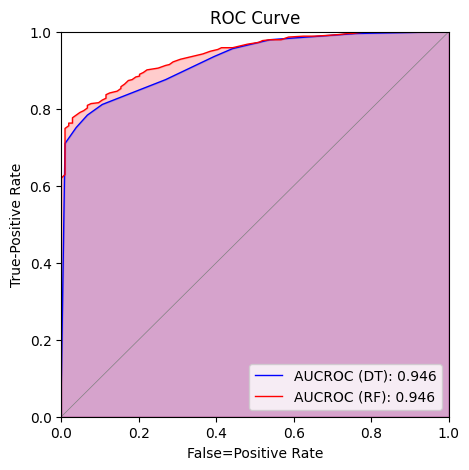

In [25]:
from sklearn.metrics import roc_auc_score

aucroc = {}
aucroc["dt"] = roc_auc_score(y_true=y[test.index], y_score=probs["dt"][:, 1])
aucroc["rf"] = roc_auc_score(y_true=y[test.index], y_score=probs["rf"][:, 1])

plt.style.use("default")
plt.figure(figsize=(5, 5))
plt.plot(fpr["dt"], tpr["dt"], color="blue", linewidth=1, label="AUCROC (DT): {}".format(round(aucroc["rf"], 3)))
plt.plot(fpr["rf"], tpr["rf"], color="red", linewidth=1, label="AUCROC (RF): {}".format(round(aucroc["rf"], 3)))
plt.plot([0, 1], [0, 1], color="gray", linewidth=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False=Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.fill_between(fpr["dt"], tpr["dt"], color="blue", alpha=0.2)
plt.fill_between(fpr["rf"], tpr["rf"], color="red", alpha=0.2)
plt.savefig("../plot/roc_dt_and_rf.svg", format="svg")

In [27]:
samples = {}
samples["dt"] = test.copy()
samples["dt"]["P(y|X)"] = probs["dt"][:, 1]
samples["dt"]["yhat"] = yhat["dt"]

samples["rf"] = test.copy()
samples["rf"]["P(y|X)"] = probs["rf"][:, 1]
samples["rf"]["yhat"] = yhat["rf"]

In [30]:
samples["dt"].head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,is_energy_saving,orientation,east,north,south,west,P(y|X),yhat
510,0.71,710.5,269.5,220.5,3.5,4,0.25,5,12.25,15.23,1,south,0,0,1,0,0.989181,1
112,0.79,637.0,343.0,147.0,7.0,2,0.10,2,35.65,41.07,1,north,0,1,0,0,0.989181,1
346,0.86,588.0,294.0,147.0,7.0,4,0.25,2,29.27,29.90,0,south,0,0,1,0,0.291944,0
89,0.64,784.0,343.0,220.5,3.5,3,0.10,1,15.20,19.43,1,east,1,0,0,0,0.989181,1
229,0.66,759.5,318.5,220.5,3.5,3,0.10,4,11.42,14.67,1,east,1,0,0,0,0.989181,1


In [31]:
samples["rf"].head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,is_energy_saving,orientation,east,north,south,west,P(y|X),yhat
510,0.71,710.5,269.5,220.5,3.5,4,0.25,5,12.25,15.23,1,south,0,0,1,0,0.985493,1
112,0.79,637.0,343.0,147.0,7.0,2,0.10,2,35.65,41.07,1,north,0,1,0,0,0.978018,1
346,0.86,588.0,294.0,147.0,7.0,4,0.25,2,29.27,29.90,0,south,0,0,1,0,0.383596,0
89,0.64,784.0,343.0,220.5,3.5,3,0.10,1,15.20,19.43,1,east,1,0,0,0,0.993064,1
229,0.66,759.5,318.5,220.5,3.5,3,0.10,4,11.42,14.67,1,east,1,0,0,0,0.992910,1


In [32]:
fp = {}
fp["dt"] = samples["dt"][(samples["dt"]["is_energy_saving"] == 0) & (samples["dt"]["yhat"] == 1)]
fp["rf"] = samples["rf"][(samples["rf"]["is_energy_saving"] == 0) & (samples["rf"]["yhat"] == 1)]

In [33]:
fp["dt"].head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,is_energy_saving,orientation,east,north,south,west,P(y|X),yhat
155,0.86,588.0,294.0,147.0,7.0,5,0.1,3,26.46,27.40,0,west,0,0,0,1,0.544118,1
249,0.86,588.0,294.0,147.0,7.0,3,0.1,5,26.45,27.33,0,east,1,0,0,0,0.608091,1


In [34]:
fp["rf"].head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,is_energy_saving,orientation,east,north,south,west,P(y|X),yhat
155,0.86,588.0,294.0,147.0,7.0,5,0.1,3,26.46,27.40,0,west,0,0,0,1,0.558838,1
249,0.86,588.0,294.0,147.0,7.0,3,0.1,5,26.45,27.33,0,east,1,0,0,0,0.506388,1


In [35]:
volume_to_surface_ratio = samples["dt"]["X1"].describe()
volume_to_surface_ratio

count    115.000000
mean       0.777565
std        0.118474
min        0.620000
25%        0.690000
50%        0.740000
75%        0.860000
max        0.980000
Name: X1, dtype: float64

In [36]:
surface_area = samples["dt"]["X2"].describe()
surface_area

count    115.000000
mean     662.991304
std       96.007218
min      514.500000
25%      588.000000
50%      686.000000
75%      735.000000
max      808.500000
Name: X2, dtype: float64

In [37]:
wall_area = samples["dt"]["X3"].describe()
wall_area

count    115.000000
mean     313.173913
std       45.173741
min      245.000000
25%      294.000000
50%      294.000000
75%      343.000000
max      416.500000
Name: X3, dtype: float64

In [38]:
roof_area = samples["dt"]["X4"].describe()
roof_area

count    115.000000
mean     174.908696
std       47.542379
min      110.250000
25%      122.500000
50%      220.500000
75%      220.500000
max      220.500000
Name: X4, dtype: float64

In [39]:
overall_height = samples["dt"]["X5"].describe()
overall_height

count    115.000000
mean       5.234783
std        1.757592
min        3.500000
25%        3.500000
50%        3.500000
75%        7.000000
max        7.000000
Name: X5, dtype: float64

In [40]:
orientation = samples["dt"]["orientation"].describe()
orientation

count       115
unique        4
top       north
freq         31
Name: orientation, dtype: object

In [41]:
glazing_area = samples["dt"]["X7"].describe()
glazing_area

count    115.000000
mean       0.222609
std        0.134138
min        0.000000
25%        0.100000
50%        0.250000
75%        0.400000
max        0.400000
Name: X7, dtype: float64

The overall building characteristics seems to be hard for heat transferred.  The harder heat transferred the less energy consumption to maintain temperature inside the building.  However, such buildings seems to be very large indicated to volume and overall height.  These characteristics could confuse our model to make non-energy saving building as an energy saving building.  

Since the False-Positive sampels from `Random Forest` are the same as `Decision Tree`, its analysis of errors follows the same as above.

# Congratulation  

Weldone.  You have completed the lab 3 (Logistic Regression).  Save your preprocess data for further used in another tool `Orange`.

In [ ]:
df.to_csv("../data/lab4-data.csv", index=False)